In [7]:
# Data
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
import impl.layer as l

# Dataset preparation and pre-processing
mnist = input_data.read_data_sets('data/MNIST_data/', one_hot=False)

X_train, y_train = mnist.train.images, mnist.train.labels
X_val, y_val = mnist.validation.images, mnist.validation.labels
X_test, y_test = mnist.test.images, mnist.test.labels

Extracting data/MNIST_data/train-images-idx3-ubyte.gz
Extracting data/MNIST_data/train-labels-idx1-ubyte.gz
Extracting data/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting data/MNIST_data/t10k-labels-idx1-ubyte.gz


In [8]:
# Pre-processing: normalizing
def normalize(X):
    # max scale for images 255= 2**8= 8 bit grayscale for each channel
    return (X - X.mean(axis=0)) #/ X.std(axis=0)

X_train, X_val, X_test = normalize(X=X_train), normalize(X=X_val), normalize(X=X_test)

In [9]:
# Model
import impl.layer as l # or from impl.layer import *
from impl.loss import * # import all functions from impl.loss file # import impl.loss as loss_func
from sklearn.utils import shuffle as skshuffle

class FFNN:

    def __init__(self, D, C, H, L):
        self.L = L # layers
        self.C = C # classes
        self.losses = {'train':[], 'train_acc':[], 
                       'valid':[], 'valid_acc':[], 
                       'test':[], 'test_acc':[]}
        
        self.model = []
        self.W_fixed = []
        self.grads = []
        self.dy_prev = np.zeros((1, C))
        self.y_prev = np.zeros((1, C))
        low, high = -1, 1
        
        # Input layer: weights/ biases
        m = dict(W=np.random.uniform(size=(D, H), low=low, high=high) / np.sqrt(D / 2.), b=np.zeros((1, H)))
        self.model.append(m)
        # Fixed feedback weight
        m = np.random.uniform(size=(D, H), low=low, high=high) / np.sqrt(D / 2.)
        self.W_fixed.append(m)
        # Input layer: gradients
        self.grads.append({key: np.zeros_like(val) for key, val in self.model[0].items()})

        # Hidden layers: weights/ biases
        m_L = []
        for _ in range(L):
            m = dict(W=np.random.uniform(size=(H, H), low=low, high=high) / np.sqrt(H / 2.), b=np.zeros((1, H)))
            m_L.append(m)
        self.model.append(m_L)
        # Fixed feedback weight
        m_L = []
        for _ in range(L):
            m = np.random.uniform(size=(H, H), low=low, high=high) / np.sqrt(H / 2.)
            m_L.append(m)
        self.W_fixed.append(m_L)
        # Hidden layer: gradients
        grad_L = []
        for _ in range(L):
            grad_L.append({key: np.zeros_like(val) for key, val in self.model[1][0].items()})
        self.grads.append(grad_L)
        
        # Output layer: weights/ biases
        m = dict(W=np.random.uniform(size=(H, C), low=low, high=high) / np.sqrt(H / 2.), b=np.zeros((1, C)))
        self.model.append(m)
        # Fixed feedback weight
        m = np.random.uniform(size=(H, C), low=low, high=high) / np.sqrt(H / 2.)
        self.W_fixed.append(m)
        # Output layer: gradients
        self.grads.append({key: np.zeros_like(val) for key, val in self.model[2].items()})
        
    def fc_forward(self, X, W, b):
        out = (X @ W) + b
        cache = (W, X)
        return out, cache

    def fc_backward(self, dout, cache, W_fixed):
        W, X = cache

        dW = X.T @ dout
        db = np.sum(dout, axis=0).reshape(1, -1) # db_1xn
        
#         dX = dout @ W.T # vanilla Backprop
        dX = dout @ W_fixed.T # fba backprop

        return dX, dW, db

    def train_forward(self, X, train):
        caches, ys = [], []
        
        # Input layer
        y, fc_cache = self.fc_forward(X=X, W=self.model[0]['W'], b=self.model[0]['b']) # X_1xD, y_1xc
        y, nl_cache = l.tanh_forward(X=y)
#         y, nl_cache = l.sigmoid_forward(X=y)
        if train:
            caches.append((fc_cache, nl_cache))
        X = y.copy() # pass to the next layer
        
        # Hidden layers
        fc_caches, nl_caches = [], []
        for layer in range(self.L):
            y, fc_cache = self.fc_forward(X=X, W=self.model[1][layer]['W'], b=self.model[1][layer]['b'])
            y, nl_cache = l.tanh_forward(X=y)
#             y, nl_cache = l.sigmoid_forward(X=y)
            X = y.copy() # pass to next layer
            if train:
                fc_caches.append(fc_cache)
                nl_caches.append(nl_cache)
        if train:
            caches.append((fc_caches, nl_caches)) # caches[1]            
        
        # Output layer
        y, fc_cache = self.fc_forward(X=X, W=self.model[2]['W'], b=self.model[2]['b'])
        y_prob = l.softmax(X=y)
        if train:
            caches.append(fc_cache)

        return y_prob, caches # for backpropating the error

    def cross_entropy(self, y_prob, y_train):
        m = y_prob.shape[0]

        #         prob = l.softmax(y_pred)
        log_like = -np.log(y_prob[range(m), y_train] + l.eps) # to avoid the devision by zero
        data_loss = np.sum(log_like) / m

        return data_loss

    def dcross_entropy(self, y_prob, y_train): # this is equal for both since the reg_loss (noise) derivative is ZERO.
        m = y_prob.shape[0]

        #         grad_y = l.softmax(y_pred)
        grad_y = y_prob
        grad_y[range(m), y_train] -= 1.
        grad_y /= m

        return grad_y

    def loss_function(self, y_prob, y_train):
        
        loss = self.cross_entropy(y_prob, y_train) # softmax is included
        dy = self.dcross_entropy(y_prob, y_train) # dsoftmax is included

        return loss, dy
        
    def train_backward(self, dy, caches, y):
        grads = self.grads.copy() # initialized by Zero in every iteration/epoch
#         dy_prev = self.dy_prev.copy() # for temporal differencing
#         self.dy_prev = dy.copy() # next iteration/ epoch
#         y_prev = self.y_prev.copy() # for temporal differencing
#         self.y_prev = y.copy() # next iteration/ epoch
        
        # Output layer
        fc_cache = caches[2]
        # softmax_backward is included in dcross_entropy.
        dX, dW, db = self.fc_backward(dout=dy, cache=fc_cache, W_fixed=self.W_fixed[2])
        dy = dX.copy()
# #         dy =  dy @ self.W_fixed[2].T # done
#         dy_prev =  dy_prev @ self.W_fixed[2].T
#         y =  y @ self.W_fixed[2].T # done
#         y_prev =  y_prev @ self.W_fixed[2].T
        grads[2]['W'] = dW
        grads[2]['b'] = db

        # Hidden layer
        fc_caches, nl_caches = caches[1]
        for layer in reversed(range(self.L)):
            dy = l.tanh_backward(cache=nl_caches[layer], dout=dy) # diffable function
#             dy = l.sigmoid_backward(cache=nl_caches[layer], dout=dy) # diffable function
#             dy *= dy - dy_prev # temporal diff instead of differentiable function
#             dy *= y - y_prev # temporal diff instead of differentiable function
            dX, dW, db = self.fc_backward(dout=dy, cache=fc_caches[layer], W_fixed=self.W_fixed[1][layer])
            dy = dX.copy()
# #             dy =  dy @ self.W_fixed[2].T # done
#             dy_prev =  dy_prev @ self.W_fixed[1][layer].T
#             y =  y @ self.W_fixed[1][layer].T # done
#             y_prev =  y_prev @ self.W_fixed[1][layer].T
            grads[1][layer]['W'] = dW
            grads[1][layer]['b'] = db
        
        # Input layer
        fc_cache, nl_cache = caches[0]
        dy = l.tanh_backward(cache=nl_cache, dout=dy) # diffable function
#         dy = l.sigmoid_backward(cache=nl_caches[layer], dout=dy) # diffable function
#         dy *= dy - dy_prev # temporal diff instead of differentiable function
#         dy *= y - y_prev # temporal diff instead of differentiable function
        dX, dW, db = self.fc_backward(dout=dy, cache=fc_cache, W_fixed=self.W_fixed[0])
        grads[0]['W'] = dW
        grads[0]['b'] = db

        return dX, grads
    
    def test(self, X):
        y_prob, _ = self.train_forward(X, train=False)
        
        # if self.mode == 'classification':
        y_pred = np.argmax(y_prob, axis=1) # for loss ==err
        
        return y_pred, y_prob
        
    def get_minibatch(self, X, y, minibatch_size, shuffle):
        minibatches = []

        if shuffle:
            X, y = skshuffle(X, y)

        for i in range(0, X.shape[0], minibatch_size):
            X_mini = X[i:i + minibatch_size]
            y_mini = y[i:i + minibatch_size]
            minibatches.append((X_mini, y_mini))

        return minibatches

    def sgd(self, train_set, val_set, alpha, mb_size, n_iter, print_after):
        X_train, y_train = train_set
        X_val, y_val = val_set

        # Epochs
        for iter in range(1, n_iter + 1):

            # Minibatches
            minibatches = self.get_minibatch(X_train, y_train, mb_size, shuffle=True)
            idx = np.random.randint(0, len(minibatches))
            X_mini, y_mini = minibatches[idx]
            
            # Train the model
            y_prob, caches = self.train_forward(X_mini, train=True)
            _, dy = self.loss_function(y_prob, y_mini)
            _, grads = self.train_backward(dy, caches, y_prob)
            
            # Update the model for input layer
            for key in grads[0].keys():
                self.model[0][key] -= alpha * grads[0][key]

            # Update the model for the hidden layers
            for layer in range(self.L):
                for key in grads[1][layer].keys():
                    self.model[1][layer][key] -= alpha * grads[1][layer][key]

            # Update the model for output layer
            for key in grads[2].keys():
                self.model[2][key] -= alpha * grads[2][key]
            
            # Training accuracy
            y_pred, y_prob = self.test(X_mini)
            loss, _ = self.loss_function(y_prob, y_mini) # softmax is included in entropy loss function
            self.losses['train'].append(loss)
            acc = np.mean(y_pred == y_mini) # confusion matrix
            self.losses['train_acc'].append(acc)

            # Validate the updated model
            y_pred, y_prob = self.test(X_val)
            valid_loss, _ = self.loss_function(y_prob, y_val) # softmax is included in entropy loss function
            self.losses['valid'].append(valid_loss)
            valid_acc = np.mean(y_pred == y_val) # confusion matrix
            self.losses['valid_acc'].append(valid_acc)
            
            # Test the final model
            y_pred, y_prob = nn.test(X_test)
            test_loss, _ = self.loss_function(y_prob, y_test) # softmax is included in entropy loss function
            self.losses['test'].append(test_loss)
            test_acc = np.mean(y_pred == y_test)
            self.losses['test_acc'].append(test_acc)
#             print('Test accuracy mean: {:.4f}, std: {:.4f}, loss: {:.4f}'.
#             format(acc.mean(), acc.std(), loss))
            
            # Print the model info: loss & accuracy or err & acc
            if iter % print_after == 0:
                print('Iter-{}, train loss-{:.4f}, acc-{:.4f}, valid loss-{:.4f}, acc-{:.4f}, test loss-{:.4f}, acc-{:.4f}'.format(
                   iter, loss, acc, valid_loss, valid_acc, test_loss, test_acc))

In [10]:
# Hyper-parameters
n_iter = 10000 # number of epochs
alpha = 1e-3 # learning_rate
mb_size = 50 # 2**10==1024 # width, timestep for sequential data or minibatch size
print_after = 10 # n_iter//10 # print loss for train, valid, and test
num_hidden_units = 32 # number of kernels/ filters in each layer
num_input_units = X_train.shape[1] # noise added at the input lavel as input noise we can use dX or for more improvement
num_output_units = y_train.max() + 1 # number of classes in this classification problem
num_layers = 2 # depth 

# Build the model/NN and learn it: running session.
nn = FFNN(C=num_output_units, D=num_input_units, H=num_hidden_units, L=num_layers)

nn.sgd(train_set=(X_train, y_train), val_set=(X_val, y_val), mb_size=mb_size, alpha=alpha, 
           n_iter=n_iter, print_after=print_after)

Iter-10, train loss-2.3411, acc-0.1000, valid loss-2.3321, acc-0.0536, test loss-2.3345, acc-0.0576
Iter-20, train loss-2.3232, acc-0.0400, valid loss-2.3320, acc-0.0540, test loss-2.3343, acc-0.0579
Iter-30, train loss-2.3223, acc-0.0400, valid loss-2.3316, acc-0.0544, test loss-2.3339, acc-0.0577
Iter-40, train loss-2.3454, acc-0.0200, valid loss-2.3313, acc-0.0554, test loss-2.3336, acc-0.0579
Iter-50, train loss-2.3123, acc-0.0600, valid loss-2.3311, acc-0.0552, test loss-2.3333, acc-0.0580
Iter-60, train loss-2.3304, acc-0.0000, valid loss-2.3308, acc-0.0552, test loss-2.3331, acc-0.0586
Iter-70, train loss-2.3281, acc-0.0400, valid loss-2.3305, acc-0.0554, test loss-2.3328, acc-0.0590
Iter-80, train loss-2.3356, acc-0.0600, valid loss-2.3303, acc-0.0558, test loss-2.3325, acc-0.0594
Iter-90, train loss-2.3341, acc-0.0200, valid loss-2.3301, acc-0.0556, test loss-2.3323, acc-0.0596
Iter-100, train loss-2.3617, acc-0.0800, valid loss-2.3299, acc-0.0550, test loss-2.3320, acc-0.0587

Iter-830, train loss-2.3208, acc-0.0600, valid loss-2.3074, acc-0.0802, test loss-2.3085, acc-0.0816
Iter-840, train loss-2.3014, acc-0.0600, valid loss-2.3069, acc-0.0808, test loss-2.3081, acc-0.0822
Iter-850, train loss-2.3057, acc-0.0600, valid loss-2.3066, acc-0.0810, test loss-2.3077, acc-0.0822
Iter-860, train loss-2.3159, acc-0.0600, valid loss-2.3061, acc-0.0810, test loss-2.3073, acc-0.0829
Iter-870, train loss-2.3097, acc-0.0600, valid loss-2.3057, acc-0.0820, test loss-2.3068, acc-0.0833
Iter-880, train loss-2.3103, acc-0.0800, valid loss-2.3052, acc-0.0826, test loss-2.3064, acc-0.0836
Iter-890, train loss-2.3184, acc-0.0000, valid loss-2.3049, acc-0.0836, test loss-2.3060, acc-0.0838
Iter-900, train loss-2.2948, acc-0.1200, valid loss-2.3045, acc-0.0836, test loss-2.3056, acc-0.0837
Iter-910, train loss-2.2769, acc-0.1200, valid loss-2.3041, acc-0.0844, test loss-2.3052, acc-0.0845
Iter-920, train loss-2.3160, acc-0.0200, valid loss-2.3037, acc-0.0846, test loss-2.3047, a

Iter-1640, train loss-2.2782, acc-0.1200, valid loss-2.2643, acc-0.1178, test loss-2.2649, acc-0.1178
Iter-1650, train loss-2.2414, acc-0.1800, valid loss-2.2636, acc-0.1188, test loss-2.2642, acc-0.1184
Iter-1660, train loss-2.2713, acc-0.2000, valid loss-2.2628, acc-0.1192, test loss-2.2635, acc-0.1189
Iter-1670, train loss-2.2541, acc-0.1600, valid loss-2.2621, acc-0.1198, test loss-2.2628, acc-0.1197
Iter-1680, train loss-2.2561, acc-0.1200, valid loss-2.2615, acc-0.1204, test loss-2.2621, acc-0.1200
Iter-1690, train loss-2.2828, acc-0.1600, valid loss-2.2608, acc-0.1210, test loss-2.2615, acc-0.1205
Iter-1700, train loss-2.2742, acc-0.1200, valid loss-2.2602, acc-0.1210, test loss-2.2609, acc-0.1208
Iter-1710, train loss-2.2678, acc-0.1400, valid loss-2.2595, acc-0.1216, test loss-2.2602, acc-0.1207
Iter-1720, train loss-2.2846, acc-0.0800, valid loss-2.2588, acc-0.1226, test loss-2.2595, acc-0.1207
Iter-1730, train loss-2.2894, acc-0.1200, valid loss-2.2581, acc-0.1226, test loss

Iter-2450, train loss-2.2043, acc-0.1400, valid loss-2.2017, acc-0.1858, test loss-2.2025, acc-0.1780
Iter-2460, train loss-2.1732, acc-0.1000, valid loss-2.2008, acc-0.1856, test loss-2.2016, acc-0.1796
Iter-2470, train loss-2.1926, acc-0.1800, valid loss-2.1999, acc-0.1876, test loss-2.2007, acc-0.1811
Iter-2480, train loss-2.2219, acc-0.2200, valid loss-2.1991, acc-0.1878, test loss-2.1999, acc-0.1829
Iter-2490, train loss-2.2210, acc-0.0800, valid loss-2.1982, acc-0.1886, test loss-2.1990, acc-0.1839
Iter-2500, train loss-2.1921, acc-0.1600, valid loss-2.1972, acc-0.1902, test loss-2.1981, acc-0.1844
Iter-2510, train loss-2.2143, acc-0.1600, valid loss-2.1963, acc-0.1912, test loss-2.1972, acc-0.1854
Iter-2520, train loss-2.2113, acc-0.1000, valid loss-2.1953, acc-0.1924, test loss-2.1962, acc-0.1865
Iter-2530, train loss-2.2595, acc-0.1200, valid loss-2.1943, acc-0.1944, test loss-2.1952, acc-0.1888
Iter-2540, train loss-2.2133, acc-0.1400, valid loss-2.1935, acc-0.1958, test loss

Iter-3260, train loss-2.1796, acc-0.1600, valid loss-2.1255, acc-0.2250, test loss-2.1267, acc-0.2274
Iter-3270, train loss-2.1306, acc-0.1400, valid loss-2.1245, acc-0.2250, test loss-2.1258, acc-0.2278
Iter-3280, train loss-2.0998, acc-0.2600, valid loss-2.1236, acc-0.2244, test loss-2.1248, acc-0.2281
Iter-3290, train loss-2.1232, acc-0.2200, valid loss-2.1226, acc-0.2246, test loss-2.1239, acc-0.2286
Iter-3300, train loss-2.1201, acc-0.1800, valid loss-2.1216, acc-0.2246, test loss-2.1229, acc-0.2292
Iter-3310, train loss-2.2139, acc-0.2000, valid loss-2.1206, acc-0.2258, test loss-2.1219, acc-0.2294
Iter-3320, train loss-2.0755, acc-0.3400, valid loss-2.1197, acc-0.2260, test loss-2.1209, acc-0.2292
Iter-3330, train loss-2.1639, acc-0.1600, valid loss-2.1187, acc-0.2258, test loss-2.1200, acc-0.2297
Iter-3340, train loss-2.1461, acc-0.2200, valid loss-2.1177, acc-0.2268, test loss-2.1190, acc-0.2303
Iter-3350, train loss-2.1085, acc-0.2000, valid loss-2.1168, acc-0.2270, test loss

Iter-4070, train loss-2.0721, acc-0.2200, valid loss-2.0449, acc-0.2736, test loss-2.0465, acc-0.2751
Iter-4080, train loss-2.1122, acc-0.2400, valid loss-2.0439, acc-0.2746, test loss-2.0454, acc-0.2757
Iter-4090, train loss-1.9987, acc-0.2800, valid loss-2.0429, acc-0.2754, test loss-2.0445, acc-0.2766
Iter-4100, train loss-1.9993, acc-0.3000, valid loss-2.0419, acc-0.2760, test loss-2.0434, acc-0.2779
Iter-4110, train loss-2.0509, acc-0.3000, valid loss-2.0409, acc-0.2766, test loss-2.0424, acc-0.2787
Iter-4120, train loss-2.1080, acc-0.2200, valid loss-2.0399, acc-0.2778, test loss-2.0415, acc-0.2792
Iter-4130, train loss-2.0941, acc-0.2000, valid loss-2.0388, acc-0.2784, test loss-2.0404, acc-0.2798
Iter-4140, train loss-2.0081, acc-0.2200, valid loss-2.0378, acc-0.2788, test loss-2.0394, acc-0.2806
Iter-4150, train loss-2.1064, acc-0.2400, valid loss-2.0367, acc-0.2786, test loss-2.0383, acc-0.2807
Iter-4160, train loss-2.0484, acc-0.2600, valid loss-2.0358, acc-0.2798, test loss

Iter-4880, train loss-1.9987, acc-0.2800, valid loss-1.9643, acc-0.3382, test loss-1.9662, acc-0.3359
Iter-4890, train loss-1.9740, acc-0.3200, valid loss-1.9634, acc-0.3390, test loss-1.9653, acc-0.3369
Iter-4900, train loss-1.9737, acc-0.3800, valid loss-1.9624, acc-0.3400, test loss-1.9643, acc-0.3383
Iter-4910, train loss-1.8979, acc-0.4000, valid loss-1.9614, acc-0.3406, test loss-1.9633, acc-0.3387
Iter-4920, train loss-1.8962, acc-0.3600, valid loss-1.9604, acc-0.3416, test loss-1.9623, acc-0.3394
Iter-4930, train loss-1.9848, acc-0.2800, valid loss-1.9595, acc-0.3422, test loss-1.9614, acc-0.3399
Iter-4940, train loss-1.8875, acc-0.4400, valid loss-1.9585, acc-0.3426, test loss-1.9604, acc-0.3405
Iter-4950, train loss-1.9478, acc-0.4400, valid loss-1.9575, acc-0.3432, test loss-1.9594, acc-0.3408
Iter-4960, train loss-1.9724, acc-0.2600, valid loss-1.9565, acc-0.3438, test loss-1.9584, acc-0.3421
Iter-4970, train loss-1.9182, acc-0.2800, valid loss-1.9556, acc-0.3446, test loss

Iter-5690, train loss-1.9250, acc-0.3800, valid loss-1.8866, acc-0.3960, test loss-1.8889, acc-0.3919
Iter-5700, train loss-1.7753, acc-0.5000, valid loss-1.8856, acc-0.3966, test loss-1.8880, acc-0.3926
Iter-5710, train loss-1.8379, acc-0.5000, valid loss-1.8847, acc-0.3978, test loss-1.8870, acc-0.3933
Iter-5720, train loss-1.9396, acc-0.3800, valid loss-1.8838, acc-0.3978, test loss-1.8861, acc-0.3937
Iter-5730, train loss-1.7966, acc-0.4200, valid loss-1.8828, acc-0.3978, test loss-1.8852, acc-0.3938
Iter-5740, train loss-1.8919, acc-0.3000, valid loss-1.8819, acc-0.3982, test loss-1.8842, acc-0.3944
Iter-5750, train loss-1.9502, acc-0.2600, valid loss-1.8810, acc-0.3994, test loss-1.8833, acc-0.3954
Iter-5760, train loss-1.8859, acc-0.3000, valid loss-1.8801, acc-0.3998, test loss-1.8824, acc-0.3965
Iter-5770, train loss-1.8527, acc-0.4200, valid loss-1.8792, acc-0.4008, test loss-1.8815, acc-0.3972
Iter-5780, train loss-2.0026, acc-0.2800, valid loss-1.8783, acc-0.4018, test loss

Iter-6500, train loss-1.9421, acc-0.3200, valid loss-1.8106, acc-0.4368, test loss-1.8133, acc-0.4345
Iter-6510, train loss-1.7503, acc-0.4600, valid loss-1.8097, acc-0.4372, test loss-1.8124, acc-0.4348
Iter-6520, train loss-1.7317, acc-0.4000, valid loss-1.8088, acc-0.4382, test loss-1.8115, acc-0.4354
Iter-6530, train loss-1.7116, acc-0.4200, valid loss-1.8078, acc-0.4380, test loss-1.8106, acc-0.4357
Iter-6540, train loss-1.7965, acc-0.4600, valid loss-1.8069, acc-0.4392, test loss-1.8097, acc-0.4360
Iter-6550, train loss-1.8256, acc-0.4200, valid loss-1.8059, acc-0.4398, test loss-1.8087, acc-0.4365
Iter-6560, train loss-1.8169, acc-0.4400, valid loss-1.8050, acc-0.4402, test loss-1.8078, acc-0.4374
Iter-6570, train loss-1.8609, acc-0.3800, valid loss-1.8041, acc-0.4404, test loss-1.8069, acc-0.4377
Iter-6580, train loss-1.7917, acc-0.4600, valid loss-1.8032, acc-0.4410, test loss-1.8060, acc-0.4387
Iter-6590, train loss-1.7705, acc-0.5200, valid loss-1.8023, acc-0.4404, test loss

Iter-7310, train loss-1.7051, acc-0.4000, valid loss-1.7347, acc-0.4630, test loss-1.7382, acc-0.4681
Iter-7320, train loss-1.7514, acc-0.4800, valid loss-1.7338, acc-0.4630, test loss-1.7373, acc-0.4689
Iter-7330, train loss-1.8333, acc-0.4400, valid loss-1.7329, acc-0.4636, test loss-1.7363, acc-0.4695
Iter-7340, train loss-1.8604, acc-0.2800, valid loss-1.7319, acc-0.4642, test loss-1.7354, acc-0.4697
Iter-7350, train loss-1.6941, acc-0.4400, valid loss-1.7310, acc-0.4644, test loss-1.7345, acc-0.4699
Iter-7360, train loss-1.6651, acc-0.5200, valid loss-1.7301, acc-0.4648, test loss-1.7336, acc-0.4703
Iter-7370, train loss-1.6145, acc-0.5400, valid loss-1.7291, acc-0.4646, test loss-1.7327, acc-0.4706
Iter-7380, train loss-1.7275, acc-0.4800, valid loss-1.7281, acc-0.4644, test loss-1.7317, acc-0.4709
Iter-7390, train loss-1.7846, acc-0.5200, valid loss-1.7272, acc-0.4644, test loss-1.7308, acc-0.4714
Iter-7400, train loss-1.6977, acc-0.3800, valid loss-1.7263, acc-0.4644, test loss

Iter-8120, train loss-1.5241, acc-0.6000, valid loss-1.6589, acc-0.4836, test loss-1.6633, acc-0.4973
Iter-8130, train loss-1.7382, acc-0.4600, valid loss-1.6581, acc-0.4842, test loss-1.6625, acc-0.4974
Iter-8140, train loss-1.7716, acc-0.3000, valid loss-1.6572, acc-0.4842, test loss-1.6616, acc-0.4983
Iter-8150, train loss-1.6846, acc-0.4200, valid loss-1.6563, acc-0.4846, test loss-1.6607, acc-0.4987
Iter-8160, train loss-1.6201, acc-0.4200, valid loss-1.6554, acc-0.4848, test loss-1.6598, acc-0.4990
Iter-8170, train loss-1.6687, acc-0.5200, valid loss-1.6545, acc-0.4852, test loss-1.6589, acc-0.4996
Iter-8180, train loss-1.6269, acc-0.5400, valid loss-1.6536, acc-0.4856, test loss-1.6580, acc-0.4996
Iter-8190, train loss-1.5595, acc-0.5200, valid loss-1.6527, acc-0.4856, test loss-1.6571, acc-0.4998
Iter-8200, train loss-1.6377, acc-0.5000, valid loss-1.6518, acc-0.4858, test loss-1.6562, acc-0.4996
Iter-8210, train loss-1.4573, acc-0.6000, valid loss-1.6508, acc-0.4858, test loss

Iter-8930, train loss-1.6361, acc-0.5000, valid loss-1.5861, acc-0.5146, test loss-1.5910, acc-0.5237
Iter-8940, train loss-1.5024, acc-0.4800, valid loss-1.5852, acc-0.5148, test loss-1.5901, acc-0.5245
Iter-8950, train loss-1.4663, acc-0.6000, valid loss-1.5843, acc-0.5150, test loss-1.5892, acc-0.5247
Iter-8960, train loss-1.4052, acc-0.6400, valid loss-1.5833, acc-0.5156, test loss-1.5882, acc-0.5249
Iter-8970, train loss-1.6316, acc-0.4400, valid loss-1.5825, acc-0.5164, test loss-1.5874, acc-0.5255
Iter-8980, train loss-1.5613, acc-0.6000, valid loss-1.5816, acc-0.5162, test loss-1.5865, acc-0.5254
Iter-8990, train loss-1.5162, acc-0.5400, valid loss-1.5806, acc-0.5164, test loss-1.5856, acc-0.5258
Iter-9000, train loss-1.7861, acc-0.4200, valid loss-1.5797, acc-0.5172, test loss-1.5847, acc-0.5261
Iter-9010, train loss-1.5586, acc-0.5600, valid loss-1.5789, acc-0.5180, test loss-1.5838, acc-0.5263
Iter-9020, train loss-1.5583, acc-0.5400, valid loss-1.5780, acc-0.5180, test loss

Iter-9740, train loss-1.5017, acc-0.6200, valid loss-1.5155, acc-0.5470, test loss-1.5208, acc-0.5542
Iter-9750, train loss-1.4119, acc-0.6000, valid loss-1.5147, acc-0.5476, test loss-1.5201, acc-0.5546
Iter-9760, train loss-1.5882, acc-0.4200, valid loss-1.5139, acc-0.5480, test loss-1.5193, acc-0.5553
Iter-9770, train loss-1.6032, acc-0.4800, valid loss-1.5130, acc-0.5484, test loss-1.5184, acc-0.5561
Iter-9780, train loss-1.6584, acc-0.4400, valid loss-1.5122, acc-0.5486, test loss-1.5175, acc-0.5569
Iter-9790, train loss-1.7140, acc-0.5200, valid loss-1.5113, acc-0.5488, test loss-1.5167, acc-0.5574
Iter-9800, train loss-1.5066, acc-0.5600, valid loss-1.5105, acc-0.5492, test loss-1.5159, acc-0.5574
Iter-9810, train loss-1.5919, acc-0.4800, valid loss-1.5096, acc-0.5496, test loss-1.5151, acc-0.5584
Iter-9820, train loss-1.4241, acc-0.6600, valid loss-1.5088, acc-0.5498, test loss-1.5142, acc-0.5589
Iter-9830, train loss-1.4917, acc-0.5000, valid loss-1.5080, acc-0.5508, test loss

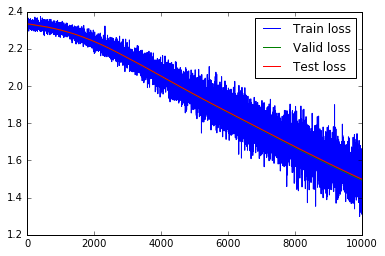

In [11]:
# # Display the learning curve and losses for training, validation, and testing
# %matplotlib inline
# %config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

plt.plot(nn.losses['train'], label='Train loss')
plt.plot(nn.losses['valid'], label='Valid loss')
plt.plot(nn.losses['test'], label='Test loss')
plt.legend()
plt.show()

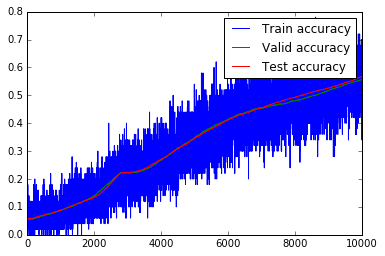

In [12]:
plt.plot(nn.losses['train_acc'], label='Train accuracy')
plt.plot(nn.losses['valid_acc'], label='Valid accuracy')
plt.plot(nn.losses['test_acc'], label='Test accuracy')
plt.legend()
plt.show()